In [1]:
# !pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 67.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import sys

2024-09-12 15:26:01.283726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 15:26:02.447309: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-09-12 15:26:02.447422: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-09-12 15:26:02.451827: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2024-09-12 15:26:02.769346: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


# Image Augmentation
- 학습데이터 부족을 해결하기 위해서 이미지에 변형을 가해 새로운 이미지를 만들어 주는 것

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

In [4]:
image = load_img('./catanddog/bird.jpg')
image_array = img_to_array(image)
image_array.shape

(703, 454, 3)

<function matplotlib.pyplot.show(close=None, block=None)>

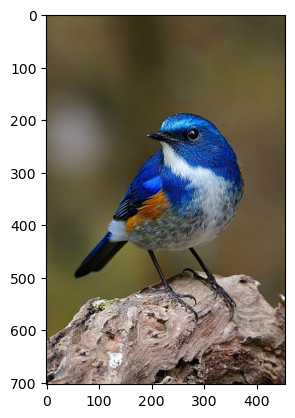

In [5]:
plt.imshow(image)
plt.show

In [6]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.3,
    height_shift_range = 0.2,
    shear_range = 0.6,
    zoom_range = 0.3,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)

In [7]:
image_array = image_array.reshape((1, ) + image_array.shape)

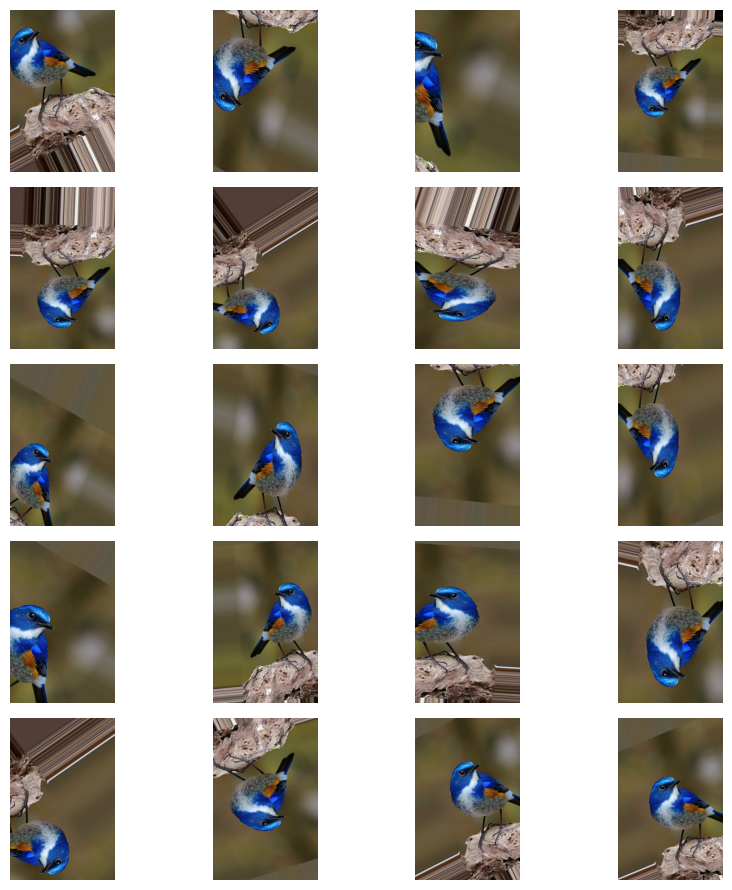

In [8]:
fig, axes = plt.subplots(5, 4, figsize = (9, 9))
axes = axes.ravel()

for i, batch in enumerate(datagen.flow(image_array, batch_size = 1)) :
    if i >= 20 : # 20개 이미지 생성 후 종료
        break
    augmented_image = array_to_img(batch[0])
    axes[i].imshow(augmented_image)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# 전이학습
- 사전에 훈련된 모델을 가지고 새로운 데이터를 넣어서 훈련하거나 결과를 출력

In [9]:
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNetRS420

In [10]:
base_model = ResNetRS420(include_top = True,
                         weights = 'imagenet',
                        input_tensor = None,
                        input_shape = None,
                        pooling = None,
                        classes = 1000)

2024-09-12 16:23:58.401243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 16:23:58.404959: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon(TM) Graphics)
2024-09-12 16:23:58.803615: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 16:23:58.803668: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2024-09-12 16:23:58.803703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

773619176/773619176 [==============================] - 25s 0us/step


In [11]:
base_model.summary()

Model: "resnet-rs-420"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 226, 226, 3)  0          ['normalization[0][0]

 BlockGroup2__block_0__se_se_ex  (None, 1, 1, 256)   16640       ['BlockGroup2__block_0__se_se_red
 pand (Conv2D)                                                   uce[0][0]']                      
                                                                                                  
 BlockGroup2__block_0__se_se_ex  (None, 56, 56, 256)  0          ['BlockGroup2__block_0__batch_nor
 cite (Multiply)                                                 m_3[0][0]',                      
                                                                  'BlockGroup2__block_0__se_se_exp
                                                                 and[0][0]']                      
                                                                                                  
 BlockGroup2__block_0__projecti  (None, 56, 56, 256)  16384      ['stem_1_stem_act_4[0][0]']      
 on_conv (Conv2D)                                                                                 
          

                                                                                                  
 BlockGroup2__block_2__act_1 (A  (None, 56, 56, 64)  0           ['BlockGroup2__block_2_batch_norm
 ctivation)                                                      _1[0][0]']                       
                                                                                                  
 BlockGroup2__block_2__conv_2 (  (None, 56, 56, 64)  36864       ['BlockGroup2__block_2__act_1[0][
 Conv2D)                                                         0]']                             
                                                                                                  
 BlockGroup2__block_2__batch_no  (None, 56, 56, 64)  256         ['BlockGroup2__block_2__conv_2[0]
 rm_2 (BatchNormalization)                                       [0]']                            
                                                                                                  
 BlockGrou

 BlockGroup2__block_3__se_se_ex  (None, 56, 56, 256)  0          ['BlockGroup2__block_3__batch_nor
 cite (Multiply)                                                 m_3[0][0]',                      
                                                                  'BlockGroup2__block_3__se_se_exp
                                                                 and[0][0]']                      
                                                                                                  
 BlockGroup2__block_3__drop (Dr  (None, 56, 56, 256)  0          ['BlockGroup2__block_3__se_se_exc
 opout)                                                          ite[0][0]']                      
                                                                                                  
 add_3 (Add)                    (None, 56, 56, 256)  0           ['BlockGroup2__block_3__drop[0][0
                                                                 ]',                              
          

                                                                                                  
 BlockGroup3__block_1_batch_nor  (None, 28, 28, 128)  512        ['BlockGroup3__block_1__conv_1[0]
 m_1 (BatchNormalization)                                        [0]']                            
                                                                                                  
 BlockGroup3__block_1__act_1 (A  (None, 28, 28, 128)  0          ['BlockGroup3__block_1_batch_norm
 ctivation)                                                      _1[0][0]']                       
                                                                                                  
 BlockGroup3__block_1__conv_2 (  (None, 28, 28, 128)  147456     ['BlockGroup3__block_1__act_1[0][
 Conv2D)                                                         0]']                             
                                                                                                  
 BlockGrou

 BlockGroup3__block_2__se_se_ex  (None, 1, 1, 512)   66048       ['BlockGroup3__block_2__se_se_red
 pand (Conv2D)                                                   uce[0][0]']                      
                                                                                                  
 BlockGroup3__block_2__se_se_ex  (None, 28, 28, 512)  0          ['BlockGroup3__block_2__batch_nor
 cite (Multiply)                                                 m_3[0][0]',                      
                                                                  'BlockGroup3__block_2__se_se_exp
                                                                 and[0][0]']                      
                                                                                                  
 BlockGroup3__block_2__drop (Dr  (None, 28, 28, 512)  0          ['BlockGroup3__block_2__se_se_exc
 opout)                                                          ite[0][0]']                      
          

 BlockGroup3__block_4__batch_no  (None, 28, 28, 128)  512        ['BlockGroup3__block_4__conv_2[0]
 rm_2 (BatchNormalization)                                       [0]']                            
                                                                                                  
 BlockGroup3__block_4__act_2 (A  (None, 28, 28, 128)  0          ['BlockGroup3__block_4__batch_nor
 ctivation)                                                      m_2[0][0]']                      
                                                                                                  
 BlockGroup3__block_4__conv_3 (  (None, 28, 28, 512)  65536      ['BlockGroup3__block_4__act_2[0][
 Conv2D)                                                         0]']                             
                                                                                                  
 BlockGroup3__block_4__batch_no  (None, 28, 28, 512)  2048       ['BlockGroup3__block_4__conv_3[0]
 rm_3 (Bat

                                                                                                  
 add_9 (Add)                    (None, 28, 28, 512)  0           ['BlockGroup3__block_5__drop[0][0
                                                                 ]',                              
                                                                  'BlockGroup3__block_4__output_ac
                                                                 t[0][0]']                        
                                                                                                  
 BlockGroup3__block_5__output_a  (None, 28, 28, 512)  0          ['add_9[0][0]']                  
 ct (Activation)                                                                                  
                                                                                                  
 BlockGroup3__block_6__conv_1 (  (None, 28, 28, 128)  65536      ['BlockGroup3__block_5__output_ac
 Conv2D)  

 rm_3 (BatchNormalization)                                       [0]']                            
                                                                                                  
 BlockGroup3__block_7__se_se_sq  (None, 512)         0           ['BlockGroup3__block_7__batch_nor
 ueeze (GlobalAveragePooling2D)                                  m_3[0][0]']                      
                                                                                                  
 BlockGroup3__block_7__se_se_re  (None, 1, 1, 512)   0           ['BlockGroup3__block_7__se_se_squ
 shape (Reshape)                                                 eeze[0][0]']                     
                                                                                                  
 BlockGroup3__block_7__se_se_re  (None, 1, 1, 128)   65664       ['BlockGroup3__block_7__se_se_res
 duce (Conv2D)                                                   hape[0][0]']                     
          

 Conv2D)                                                         t[0][0]']                        
                                                                                                  
 BlockGroup3__block_9_batch_nor  (None, 28, 28, 128)  512        ['BlockGroup3__block_9__conv_1[0]
 m_1 (BatchNormalization)                                        [0]']                            
                                                                                                  
 BlockGroup3__block_9__act_1 (A  (None, 28, 28, 128)  0          ['BlockGroup3__block_9_batch_norm
 ctivation)                                                      _1[0][0]']                       
                                                                                                  
 BlockGroup3__block_9__conv_2 (  (None, 28, 28, 128)  147456     ['BlockGroup3__block_9__act_1[0][
 Conv2D)                                                         0]']                             
          

 educe (Conv2D)                                                  shape[0][0]']                    
                                                                                                  
 BlockGroup3__block_10__se_se_e  (None, 1, 1, 512)   66048       ['BlockGroup3__block_10__se_se_re
 xpand (Conv2D)                                                  duce[0][0]']                     
                                                                                                  
 BlockGroup3__block_10__se_se_e  (None, 28, 28, 512)  0          ['BlockGroup3__block_10__batch_no
 xcite (Multiply)                                                rm_3[0][0]',                     
                                                                  'BlockGroup3__block_10__se_se_ex
                                                                 pand[0][0]']                     
                                                                                                  
 BlockGrou

 BlockGroup3__block_12__conv_2   (None, 28, 28, 128)  147456     ['BlockGroup3__block_12__act_1[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup3__block_12__batch_n  (None, 28, 28, 128)  512        ['BlockGroup3__block_12__conv_2[0
 orm_2 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGroup3__block_12__act_2 (  (None, 28, 28, 128)  0          ['BlockGroup3__block_12__batch_no
 Activation)                                                     rm_2[0][0]']                     
                                                                                                  
 BlockGroup3__block_12__conv_3   (None, 28, 28, 512)  65536      ['BlockGroup3__block_12__act_2[0]
 (Conv2D) 

                                                                  'BlockGroup3__block_13__se_se_ex
                                                                 pand[0][0]']                     
                                                                                                  
 BlockGroup3__block_13__drop (D  (None, 28, 28, 512)  0          ['BlockGroup3__block_13__se_se_ex
 ropout)                                                         cite[0][0]']                     
                                                                                                  
 add_17 (Add)                   (None, 28, 28, 512)  0           ['BlockGroup3__block_13__drop[0][
                                                                 0]',                             
                                                                  'BlockGroup3__block_12__output_a
                                                                 ct[0][0]']                       
          

 Activation)                                                     rm_2[0][0]']                     
                                                                                                  
 BlockGroup3__block_15__conv_3   (None, 28, 28, 512)  65536      ['BlockGroup3__block_15__act_2[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup3__block_15__batch_n  (None, 28, 28, 512)  2048       ['BlockGroup3__block_15__conv_3[0
 orm_3 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGroup3__block_15__se_se_s  (None, 512)         0           ['BlockGroup3__block_15__batch_no
 queeze (GlobalAveragePooling2D                                  rm_3[0][0]']                     
 )        

                                                                 0]',                             
                                                                  'BlockGroup3__block_15__output_a
                                                                 ct[0][0]']                       
                                                                                                  
 BlockGroup3__block_16__output_  (None, 28, 28, 512)  0          ['add_20[0][0]']                 
 act (Activation)                                                                                 
                                                                                                  
 BlockGroup3__block_17__conv_1   (None, 28, 28, 128)  65536      ['BlockGroup3__block_16__output_a
 (Conv2D)                                                        ct[0][0]']                       
                                                                                                  
 BlockGrou

                                                                                                  
 BlockGroup3__block_18__se_se_s  (None, 512)         0           ['BlockGroup3__block_18__batch_no
 queeze (GlobalAveragePooling2D                                  rm_3[0][0]']                     
 )                                                                                                
                                                                                                  
 BlockGroup3__block_18__se_se_r  (None, 1, 1, 512)   0           ['BlockGroup3__block_18__se_se_sq
 eshape (Reshape)                                                ueeze[0][0]']                    
                                                                                                  
 BlockGroup3__block_18__se_se_r  (None, 1, 1, 128)   65664       ['BlockGroup3__block_18__se_se_re
 educe (Conv2D)                                                  shape[0][0]']                    
          

 BlockGroup3__block_20__conv_1   (None, 28, 28, 128)  65536      ['BlockGroup3__block_19__output_a
 (Conv2D)                                                        ct[0][0]']                       
                                                                                                  
 BlockGroup3__block_20_batch_no  (None, 28, 28, 128)  512        ['BlockGroup3__block_20__conv_1[0
 rm_1 (BatchNormalization)                                       ][0]']                           
                                                                                                  
 BlockGroup3__block_20__act_1 (  (None, 28, 28, 128)  0          ['BlockGroup3__block_20_batch_nor
 Activation)                                                     m_1[0][0]']                      
                                                                                                  
 BlockGroup3__block_20__conv_2   (None, 28, 28, 128)  147456     ['BlockGroup3__block_20__act_1[0]
 (Conv2D) 

                                                                                                  
 BlockGroup3__block_21__se_se_r  (None, 1, 1, 128)   65664       ['BlockGroup3__block_21__se_se_re
 educe (Conv2D)                                                  shape[0][0]']                    
                                                                                                  
 BlockGroup3__block_21__se_se_e  (None, 1, 1, 512)   66048       ['BlockGroup3__block_21__se_se_re
 xpand (Conv2D)                                                  duce[0][0]']                     
                                                                                                  
 BlockGroup3__block_21__se_se_e  (None, 28, 28, 512)  0          ['BlockGroup3__block_21__batch_no
 xcite (Multiply)                                                rm_3[0][0]',                     
                                                                  'BlockGroup3__block_21__se_se_ex
          

 Activation)                                                     m_1[0][0]']                      
                                                                                                  
 BlockGroup3__block_23__conv_2   (None, 28, 28, 128)  147456     ['BlockGroup3__block_23__act_1[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup3__block_23__batch_n  (None, 28, 28, 128)  512        ['BlockGroup3__block_23__conv_2[0
 orm_2 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGroup3__block_23__act_2 (  (None, 28, 28, 128)  0          ['BlockGroup3__block_23__batch_no
 Activation)                                                     rm_2[0][0]']                     
          

 BlockGroup3__block_24__se_se_e  (None, 28, 28, 512)  0          ['BlockGroup3__block_24__batch_no
 xcite (Multiply)                                                rm_3[0][0]',                     
                                                                  'BlockGroup3__block_24__se_se_ex
                                                                 pand[0][0]']                     
                                                                                                  
 BlockGroup3__block_24__drop (D  (None, 28, 28, 512)  0          ['BlockGroup3__block_24__se_se_ex
 ropout)                                                         cite[0][0]']                     
                                                                                                  
 add_28 (Add)                   (None, 28, 28, 512)  0           ['BlockGroup3__block_24__drop[0][
                                                                 0]',                             
          

                                                                                                  
 BlockGroup3__block_26__act_2 (  (None, 28, 28, 128)  0          ['BlockGroup3__block_26__batch_no
 Activation)                                                     rm_2[0][0]']                     
                                                                                                  
 BlockGroup3__block_26__conv_3   (None, 28, 28, 512)  65536      ['BlockGroup3__block_26__act_2[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup3__block_26__batch_n  (None, 28, 28, 512)  2048       ['BlockGroup3__block_26__conv_3[0
 orm_3 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGrou

                                                                                                  
 add_31 (Add)                   (None, 28, 28, 512)  0           ['BlockGroup3__block_27__drop[0][
                                                                 0]',                             
                                                                  'BlockGroup3__block_26__output_a
                                                                 ct[0][0]']                       
                                                                                                  
 BlockGroup3__block_27__output_  (None, 28, 28, 512)  0          ['add_31[0][0]']                 
 act (Activation)                                                                                 
                                                                                                  
 BlockGroup3__block_28__conv_1   (None, 28, 28, 128)  65536      ['BlockGroup3__block_27__output_a
 (Conv2D) 

 BlockGroup3__block_29__batch_n  (None, 28, 28, 512)  2048       ['BlockGroup3__block_29__conv_3[0
 orm_3 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGroup3__block_29__se_se_s  (None, 512)         0           ['BlockGroup3__block_29__batch_no
 queeze (GlobalAveragePooling2D                                  rm_3[0][0]']                     
 )                                                                                                
                                                                                                  
 BlockGroup3__block_29__se_se_r  (None, 1, 1, 512)   0           ['BlockGroup3__block_29__se_se_sq
 eshape (Reshape)                                                ueeze[0][0]']                    
                                                                                                  
 BlockGrou

 act (Activation)                                                                                 
                                                                                                  
 BlockGroup3__block_31__conv_1   (None, 28, 28, 128)  65536      ['BlockGroup3__block_30__output_a
 (Conv2D)                                                        ct[0][0]']                       
                                                                                                  
 BlockGroup3__block_31_batch_no  (None, 28, 28, 128)  512        ['BlockGroup3__block_31__conv_1[0
 rm_1 (BatchNormalization)                                       ][0]']                           
                                                                                                  
 BlockGroup3__block_31__act_1 (  (None, 28, 28, 128)  0          ['BlockGroup3__block_31_batch_nor
 Activation)                                                     m_1[0][0]']                      
          

 BlockGroup3__block_32__se_se_r  (None, 1, 1, 512)   0           ['BlockGroup3__block_32__se_se_sq
 eshape (Reshape)                                                ueeze[0][0]']                    
                                                                                                  
 BlockGroup3__block_32__se_se_r  (None, 1, 1, 128)   65664       ['BlockGroup3__block_32__se_se_re
 educe (Conv2D)                                                  shape[0][0]']                    
                                                                                                  
 BlockGroup3__block_32__se_se_e  (None, 1, 1, 512)   66048       ['BlockGroup3__block_32__se_se_re
 xpand (Conv2D)                                                  duce[0][0]']                     
                                                                                                  
 BlockGroup3__block_32__se_se_e  (None, 28, 28, 512)  0          ['BlockGroup3__block_32__batch_no
 xcite (Mu

                                                                                                  
 BlockGroup3__block_34__act_1 (  (None, 28, 28, 128)  0          ['BlockGroup3__block_34_batch_nor
 Activation)                                                     m_1[0][0]']                      
                                                                                                  
 BlockGroup3__block_34__conv_2   (None, 28, 28, 128)  147456     ['BlockGroup3__block_34__act_1[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup3__block_34__batch_n  (None, 28, 28, 128)  512        ['BlockGroup3__block_34__conv_2[0
 orm_2 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGrou

 xpand (Conv2D)                                                  duce[0][0]']                     
                                                                                                  
 BlockGroup3__block_35__se_se_e  (None, 28, 28, 512)  0          ['BlockGroup3__block_35__batch_no
 xcite (Multiply)                                                rm_3[0][0]',                     
                                                                  'BlockGroup3__block_35__se_se_ex
                                                                 pand[0][0]']                     
                                                                                                  
 BlockGroup3__block_35__drop (D  (None, 28, 28, 512)  0          ['BlockGroup3__block_35__se_se_ex
 ropout)                                                         cite[0][0]']                     
                                                                                                  
 add_39 (A

 BlockGroup3__block_37__batch_n  (None, 28, 28, 128)  512        ['BlockGroup3__block_37__conv_2[0
 orm_2 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGroup3__block_37__act_2 (  (None, 28, 28, 128)  0          ['BlockGroup3__block_37__batch_no
 Activation)                                                     rm_2[0][0]']                     
                                                                                                  
 BlockGroup3__block_37__conv_3   (None, 28, 28, 512)  65536      ['BlockGroup3__block_37__act_2[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup3__block_37__batch_n  (None, 28, 28, 512)  2048       ['BlockGroup3__block_37__conv_3[0
 orm_3 (Ba

 BlockGroup3__block_38__drop (D  (None, 28, 28, 512)  0          ['BlockGroup3__block_38__se_se_ex
 ropout)                                                         cite[0][0]']                     
                                                                                                  
 add_42 (Add)                   (None, 28, 28, 512)  0           ['BlockGroup3__block_38__drop[0][
                                                                 0]',                             
                                                                  'BlockGroup3__block_37__output_a
                                                                 ct[0][0]']                       
                                                                                                  
 BlockGroup3__block_38__output_  (None, 28, 28, 512)  0          ['add_42[0][0]']                 
 act (Activation)                                                                                 
          

 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup3__block_40__batch_n  (None, 28, 28, 512)  2048       ['BlockGroup3__block_40__conv_3[0
 orm_3 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGroup3__block_40__se_se_s  (None, 512)         0           ['BlockGroup3__block_40__batch_no
 queeze (GlobalAveragePooling2D                                  rm_3[0][0]']                     
 )                                                                                                
                                                                                                  
 BlockGroup3__block_40__se_se_r  (None, 1, 1, 512)   0           ['BlockGroup3__block_40__se_se_sq
 eshape (R

                                                                                                  
 BlockGroup3__block_41__output_  (None, 28, 28, 512)  0          ['add_45[0][0]']                 
 act (Activation)                                                                                 
                                                                                                  
 BlockGroup3__block_42__conv_1   (None, 28, 28, 128)  65536      ['BlockGroup3__block_41__output_a
 (Conv2D)                                                        ct[0][0]']                       
                                                                                                  
 BlockGroup3__block_42_batch_no  (None, 28, 28, 128)  512        ['BlockGroup3__block_42__conv_1[0
 rm_1 (BatchNormalization)                                       ][0]']                           
                                                                                                  
 BlockGrou

 )                                                                                                
                                                                                                  
 BlockGroup3__block_43__se_se_r  (None, 1, 1, 512)   0           ['BlockGroup3__block_43__se_se_sq
 eshape (Reshape)                                                ueeze[0][0]']                    
                                                                                                  
 BlockGroup3__block_43__se_se_r  (None, 1, 1, 128)   65664       ['BlockGroup3__block_43__se_se_re
 educe (Conv2D)                                                  shape[0][0]']                    
                                                                                                  
 BlockGroup3__block_43__se_se_e  (None, 1, 1, 512)   66048       ['BlockGroup3__block_43__se_se_re
 xpand (Conv2D)                                                  duce[0][0]']                     
          

                                                                                                  
 add_48 (Add)                   (None, 14, 14, 1024  0           ['BlockGroup4__block_0__drop[0][0
                                )                                ]',                              
                                                                  'BlockGroup4__block_0__projectio
                                                                 n_batch_norm[0][0]']             
                                                                                                  
 BlockGroup4__block_0__output_a  (None, 14, 14, 1024  0          ['add_48[0][0]']                 
 ct (Activation)                )                                                                 
                                                                                                  
 BlockGroup4__block_1__conv_1 (  (None, 14, 14, 256)  262144     ['BlockGroup4__block_0__output_ac
 Conv2D)  

 rm_3 (BatchNormalization)      )                                [0]']                            
                                                                                                  
 BlockGroup4__block_2__se_se_sq  (None, 1024)        0           ['BlockGroup4__block_2__batch_nor
 ueeze (GlobalAveragePooling2D)                                  m_3[0][0]']                      
                                                                                                  
 BlockGroup4__block_2__se_se_re  (None, 1, 1, 1024)  0           ['BlockGroup4__block_2__se_se_squ
 shape (Reshape)                                                 eeze[0][0]']                     
                                                                                                  
 BlockGroup4__block_2__se_se_re  (None, 1, 1, 256)   262400      ['BlockGroup4__block_2__se_se_res
 duce (Conv2D)                                                   hape[0][0]']                     
          

 Conv2D)                                                         t[0][0]']                        
                                                                                                  
 BlockGroup4__block_4_batch_nor  (None, 14, 14, 256)  1024       ['BlockGroup4__block_4__conv_1[0]
 m_1 (BatchNormalization)                                        [0]']                            
                                                                                                  
 BlockGroup4__block_4__act_1 (A  (None, 14, 14, 256)  0          ['BlockGroup4__block_4_batch_norm
 ctivation)                                                      _1[0][0]']                       
                                                                                                  
 BlockGroup4__block_4__conv_2 (  (None, 14, 14, 256)  589824     ['BlockGroup4__block_4__act_1[0][
 Conv2D)                                                         0]']                             
          

                                                                                                  
 BlockGroup4__block_5__se_se_ex  (None, 1, 1, 1024)  263168      ['BlockGroup4__block_5__se_se_red
 pand (Conv2D)                                                   uce[0][0]']                      
                                                                                                  
 BlockGroup4__block_5__se_se_ex  (None, 14, 14, 1024  0          ['BlockGroup4__block_5__batch_nor
 cite (Multiply)                )                                m_3[0][0]',                      
                                                                  'BlockGroup4__block_5__se_se_exp
                                                                 and[0][0]']                      
                                                                                                  
 BlockGroup4__block_5__drop (Dr  (None, 14, 14, 1024  0          ['BlockGroup4__block_5__se_se_exc
 opout)   

                                                                                                  
 BlockGroup4__block_7__batch_no  (None, 14, 14, 256)  1024       ['BlockGroup4__block_7__conv_2[0]
 rm_2 (BatchNormalization)                                       [0]']                            
                                                                                                  
 BlockGroup4__block_7__act_2 (A  (None, 14, 14, 256)  0          ['BlockGroup4__block_7__batch_nor
 ctivation)                                                      m_2[0][0]']                      
                                                                                                  
 BlockGroup4__block_7__conv_3 (  (None, 14, 14, 1024  262144     ['BlockGroup4__block_7__act_2[0][
 Conv2D)                        )                                0]']                             
                                                                                                  
 BlockGrou

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 BlockGroup4__block_35__act_1 (  (None, 14, 14, 256)  0          ['BlockGroup4__block_35_batch_nor
 Activation)                                                     m_1[0][0]']                      
                                                                                                  
 BlockGroup4__block_35__conv_2   (None, 14, 14, 256)  589824     ['BlockGroup4__block_35__act_1[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup4__block_35__batch_n  (None, 14, 14, 256)  1024       ['BlockGroup4__block_35__conv_2[0
 orm_2 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGroup4__block_35__act_2 (  (None, 14, 14, 256)  0          ['BlockGroup4__block_35__batch_no
 Activatio

                                                                                                  
 BlockGroup4__block_36__se_se_e  (None, 14, 14, 1024  0          ['BlockGroup4__block_36__batch_no
 xcite (Multiply)               )                                rm_3[0][0]',                     
                                                                  'BlockGroup4__block_36__se_se_ex
                                                                 pand[0][0]']                     
                                                                                                  
 BlockGroup4__block_36__drop (D  (None, 14, 14, 1024  0          ['BlockGroup4__block_36__se_se_ex
 ropout)                        )                                cite[0][0]']                     
                                                                                                  
 add_84 (Add)                   (None, 14, 14, 1024  0           ['BlockGroup4__block_36__drop[0][
          

 orm_2 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGroup4__block_38__act_2 (  (None, 14, 14, 256)  0          ['BlockGroup4__block_38__batch_no
 Activation)                                                     rm_2[0][0]']                     
                                                                                                  
 BlockGroup4__block_38__conv_3   (None, 14, 14, 1024  262144     ['BlockGroup4__block_38__act_2[0]
 (Conv2D)                       )                                [0]']                            
                                                                                                  
 BlockGroup4__block_38__batch_n  (None, 14, 14, 1024  4096       ['BlockGroup4__block_38__conv_3[0
 orm_3 (BatchNormalization)     )                                ][0]']                           
          

 ropout)                        )                                cite[0][0]']                     
                                                                                                  
 add_87 (Add)                   (None, 14, 14, 1024  0           ['BlockGroup4__block_39__drop[0][
                                )                                0]',                             
                                                                  'BlockGroup4__block_38__output_a
                                                                 ct[0][0]']                       
                                                                                                  
 BlockGroup4__block_39__output_  (None, 14, 14, 1024  0          ['add_87[0][0]']                 
 act (Activation)               )                                                                 
                                                                                                  
 BlockGrou

                                                                                                  
 BlockGroup4__block_41__batch_n  (None, 14, 14, 1024  4096       ['BlockGroup4__block_41__conv_3[0
 orm_3 (BatchNormalization)     )                                ][0]']                           
                                                                                                  
 BlockGroup4__block_41__se_se_s  (None, 1024)        0           ['BlockGroup4__block_41__batch_no
 queeze (GlobalAveragePooling2D                                  rm_3[0][0]']                     
 )                                                                                                
                                                                                                  
 BlockGroup4__block_41__se_se_r  (None, 1, 1, 1024)  0           ['BlockGroup4__block_41__se_se_sq
 eshape (Reshape)                                                ueeze[0][0]']                    
          

 BlockGroup4__block_42__output_  (None, 14, 14, 1024  0          ['add_90[0][0]']                 
 act (Activation)               )                                                                 
                                                                                                  
 BlockGroup4__block_43__conv_1   (None, 14, 14, 256)  262144     ['BlockGroup4__block_42__output_a
 (Conv2D)                                                        ct[0][0]']                       
                                                                                                  
 BlockGroup4__block_43_batch_no  (None, 14, 14, 256)  1024       ['BlockGroup4__block_43__conv_1[0
 rm_1 (BatchNormalization)                                       ][0]']                           
                                                                                                  
 BlockGroup4__block_43__act_1 (  (None, 14, 14, 256)  0          ['BlockGroup4__block_43_batch_nor
 Activatio

                                                                                                  
 BlockGroup4__block_44__se_se_r  (None, 1, 1, 1024)  0           ['BlockGroup4__block_44__se_se_sq
 eshape (Reshape)                                                ueeze[0][0]']                    
                                                                                                  
 BlockGroup4__block_44__se_se_r  (None, 1, 1, 256)   262400      ['BlockGroup4__block_44__se_se_re
 educe (Conv2D)                                                  shape[0][0]']                    
                                                                                                  
 BlockGroup4__block_44__se_se_e  (None, 1, 1, 1024)  263168      ['BlockGroup4__block_44__se_se_re
 xpand (Conv2D)                                                  duce[0][0]']                     
                                                                                                  
 BlockGrou

 rm_1 (BatchNormalization)                                       ][0]']                           
                                                                                                  
 BlockGroup4__block_46__act_1 (  (None, 14, 14, 256)  0          ['BlockGroup4__block_46_batch_nor
 Activation)                                                     m_1[0][0]']                      
                                                                                                  
 BlockGroup4__block_46__conv_2   (None, 14, 14, 256)  589824     ['BlockGroup4__block_46__act_1[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup4__block_46__batch_n  (None, 14, 14, 256)  1024       ['BlockGroup4__block_46__conv_2[0
 orm_2 (BatchNormalization)                                      ][0]']                           
          

 BlockGroup4__block_47__se_se_e  (None, 1, 1, 1024)  263168      ['BlockGroup4__block_47__se_se_re
 xpand (Conv2D)                                                  duce[0][0]']                     
                                                                                                  
 BlockGroup4__block_47__se_se_e  (None, 14, 14, 1024  0          ['BlockGroup4__block_47__batch_no
 xcite (Multiply)               )                                rm_3[0][0]',                     
                                                                  'BlockGroup4__block_47__se_se_ex
                                                                 pand[0][0]']                     
                                                                                                  
 BlockGroup4__block_47__drop (D  (None, 14, 14, 1024  0          ['BlockGroup4__block_47__se_se_ex
 ropout)                        )                                cite[0][0]']                     
          

                                                                                                  
 BlockGroup4__block_49__batch_n  (None, 14, 14, 256)  1024       ['BlockGroup4__block_49__conv_2[0
 orm_2 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGroup4__block_49__act_2 (  (None, 14, 14, 256)  0          ['BlockGroup4__block_49__batch_no
 Activation)                                                     rm_2[0][0]']                     
                                                                                                  
 BlockGroup4__block_49__conv_3   (None, 14, 14, 1024  262144     ['BlockGroup4__block_49__act_2[0]
 (Conv2D)                       )                                [0]']                            
                                                                                                  
 BlockGrou

                                                                                                  
 BlockGroup4__block_50__drop (D  (None, 14, 14, 1024  0          ['BlockGroup4__block_50__se_se_ex
 ropout)                        )                                cite[0][0]']                     
                                                                                                  
 add_98 (Add)                   (None, 14, 14, 1024  0           ['BlockGroup4__block_50__drop[0][
                                )                                0]',                             
                                                                  'BlockGroup4__block_49__output_a
                                                                 ct[0][0]']                       
                                                                                                  
 BlockGroup4__block_50__output_  (None, 14, 14, 1024  0          ['add_98[0][0]']                 
 act (Acti

 BlockGroup4__block_52__conv_3   (None, 14, 14, 1024  262144     ['BlockGroup4__block_52__act_2[0]
 (Conv2D)                       )                                [0]']                            
                                                                                                  
 BlockGroup4__block_52__batch_n  (None, 14, 14, 1024  4096       ['BlockGroup4__block_52__conv_3[0
 orm_3 (BatchNormalization)     )                                ][0]']                           
                                                                                                  
 BlockGroup4__block_52__se_se_s  (None, 1024)        0           ['BlockGroup4__block_52__batch_no
 queeze (GlobalAveragePooling2D                                  rm_3[0][0]']                     
 )                                                                                                
                                                                                                  
 BlockGrou

                                                                 ct[0][0]']                       
                                                                                                  
 BlockGroup4__block_53__output_  (None, 14, 14, 1024  0          ['add_101[0][0]']                
 act (Activation)               )                                                                 
                                                                                                  
 BlockGroup4__block_54__conv_1   (None, 14, 14, 256)  262144     ['BlockGroup4__block_53__output_a
 (Conv2D)                                                        ct[0][0]']                       
                                                                                                  
 BlockGroup4__block_54_batch_no  (None, 14, 14, 256)  1024       ['BlockGroup4__block_54__conv_1[0
 rm_1 (BatchNormalization)                                       ][0]']                           
          

 queeze (GlobalAveragePooling2D                                  rm_3[0][0]']                     
 )                                                                                                
                                                                                                  
 BlockGroup4__block_55__se_se_r  (None, 1, 1, 1024)  0           ['BlockGroup4__block_55__se_se_sq
 eshape (Reshape)                                                ueeze[0][0]']                    
                                                                                                  
 BlockGroup4__block_55__se_se_r  (None, 1, 1, 256)   262400      ['BlockGroup4__block_55__se_se_re
 educe (Conv2D)                                                  shape[0][0]']                    
                                                                                                  
 BlockGroup4__block_55__se_se_e  (None, 1, 1, 1024)  263168      ['BlockGroup4__block_55__se_se_re
 xpand (Co

                                                                                                  
 BlockGroup4__block_57_batch_no  (None, 14, 14, 256)  1024       ['BlockGroup4__block_57__conv_1[0
 rm_1 (BatchNormalization)                                       ][0]']                           
                                                                                                  
 BlockGroup4__block_57__act_1 (  (None, 14, 14, 256)  0          ['BlockGroup4__block_57_batch_nor
 Activation)                                                     m_1[0][0]']                      
                                                                                                  
 BlockGroup4__block_57__conv_2   (None, 14, 14, 256)  589824     ['BlockGroup4__block_57__act_1[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGrou

 educe (Conv2D)                                                  shape[0][0]']                    
                                                                                                  
 BlockGroup4__block_58__se_se_e  (None, 1, 1, 1024)  263168      ['BlockGroup4__block_58__se_se_re
 xpand (Conv2D)                                                  duce[0][0]']                     
                                                                                                  
 BlockGroup4__block_58__se_se_e  (None, 14, 14, 1024  0          ['BlockGroup4__block_58__batch_no
 xcite (Multiply)               )                                rm_3[0][0]',                     
                                                                  'BlockGroup4__block_58__se_se_ex
                                                                 pand[0][0]']                     
                                                                                                  
 BlockGrou

 BlockGroup4__block_60__conv_2   (None, 14, 14, 256)  589824     ['BlockGroup4__block_60__act_1[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup4__block_60__batch_n  (None, 14, 14, 256)  1024       ['BlockGroup4__block_60__conv_2[0
 orm_2 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGroup4__block_60__act_2 (  (None, 14, 14, 256)  0          ['BlockGroup4__block_60__batch_no
 Activation)                                                     rm_2[0][0]']                     
                                                                                                  
 BlockGroup4__block_60__conv_3   (None, 14, 14, 1024  262144     ['BlockGroup4__block_60__act_2[0]
 (Conv2D) 

                                                                  'BlockGroup4__block_61__se_se_ex
                                                                 pand[0][0]']                     
                                                                                                  
 BlockGroup4__block_61__drop (D  (None, 14, 14, 1024  0          ['BlockGroup4__block_61__se_se_ex
 ropout)                        )                                cite[0][0]']                     
                                                                                                  
 add_109 (Add)                  (None, 14, 14, 1024  0           ['BlockGroup4__block_61__drop[0][
                                )                                0]',                             
                                                                  'BlockGroup4__block_60__output_a
                                                                 ct[0][0]']                       
          

 Activation)                                                     rm_2[0][0]']                     
                                                                                                  
 BlockGroup4__block_63__conv_3   (None, 14, 14, 1024  262144     ['BlockGroup4__block_63__act_2[0]
 (Conv2D)                       )                                [0]']                            
                                                                                                  
 BlockGroup4__block_63__batch_n  (None, 14, 14, 1024  4096       ['BlockGroup4__block_63__conv_3[0
 orm_3 (BatchNormalization)     )                                ][0]']                           
                                                                                                  
 BlockGroup4__block_63__se_se_s  (None, 1024)        0           ['BlockGroup4__block_63__batch_no
 queeze (GlobalAveragePooling2D                                  rm_3[0][0]']                     
 )        

                                )                                0]',                             
                                                                  'BlockGroup4__block_63__output_a
                                                                 ct[0][0]']                       
                                                                                                  
 BlockGroup4__block_64__output_  (None, 14, 14, 1024  0          ['add_112[0][0]']                
 act (Activation)               )                                                                 
                                                                                                  
 BlockGroup4__block_65__conv_1   (None, 14, 14, 256)  262144     ['BlockGroup4__block_64__output_a
 (Conv2D)                                                        ct[0][0]']                       
                                                                                                  
 BlockGrou

                                                                                                  
 BlockGroup4__block_66__se_se_s  (None, 1024)        0           ['BlockGroup4__block_66__batch_no
 queeze (GlobalAveragePooling2D                                  rm_3[0][0]']                     
 )                                                                                                
                                                                                                  
 BlockGroup4__block_66__se_se_r  (None, 1, 1, 1024)  0           ['BlockGroup4__block_66__se_se_sq
 eshape (Reshape)                                                ueeze[0][0]']                    
                                                                                                  
 BlockGroup4__block_66__se_se_r  (None, 1, 1, 256)   262400      ['BlockGroup4__block_66__se_se_re
 educe (Conv2D)                                                  shape[0][0]']                    
          

 BlockGroup4__block_68__conv_1   (None, 14, 14, 256)  262144     ['BlockGroup4__block_67__output_a
 (Conv2D)                                                        ct[0][0]']                       
                                                                                                  
 BlockGroup4__block_68_batch_no  (None, 14, 14, 256)  1024       ['BlockGroup4__block_68__conv_1[0
 rm_1 (BatchNormalization)                                       ][0]']                           
                                                                                                  
 BlockGroup4__block_68__act_1 (  (None, 14, 14, 256)  0          ['BlockGroup4__block_68_batch_nor
 Activation)                                                     m_1[0][0]']                      
                                                                                                  
 BlockGroup4__block_68__conv_2   (None, 14, 14, 256)  589824     ['BlockGroup4__block_68__act_1[0]
 (Conv2D) 

                                                                                                  
 BlockGroup4__block_69__se_se_r  (None, 1, 1, 256)   262400      ['BlockGroup4__block_69__se_se_re
 educe (Conv2D)                                                  shape[0][0]']                    
                                                                                                  
 BlockGroup4__block_69__se_se_e  (None, 1, 1, 1024)  263168      ['BlockGroup4__block_69__se_se_re
 xpand (Conv2D)                                                  duce[0][0]']                     
                                                                                                  
 BlockGroup4__block_69__se_se_e  (None, 14, 14, 1024  0          ['BlockGroup4__block_69__batch_no
 xcite (Multiply)               )                                rm_3[0][0]',                     
                                                                  'BlockGroup4__block_69__se_se_ex
          

 Activation)                                                     m_1[0][0]']                      
                                                                                                  
 BlockGroup4__block_71__conv_2   (None, 14, 14, 256)  589824     ['BlockGroup4__block_71__act_1[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup4__block_71__batch_n  (None, 14, 14, 256)  1024       ['BlockGroup4__block_71__conv_2[0
 orm_2 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGroup4__block_71__act_2 (  (None, 14, 14, 256)  0          ['BlockGroup4__block_71__batch_no
 Activation)                                                     rm_2[0][0]']                     
          

 BlockGroup4__block_72__se_se_e  (None, 14, 14, 1024  0          ['BlockGroup4__block_72__batch_no
 xcite (Multiply)               )                                rm_3[0][0]',                     
                                                                  'BlockGroup4__block_72__se_se_ex
                                                                 pand[0][0]']                     
                                                                                                  
 BlockGroup4__block_72__drop (D  (None, 14, 14, 1024  0          ['BlockGroup4__block_72__se_se_ex
 ropout)                        )                                cite[0][0]']                     
                                                                                                  
 add_120 (Add)                  (None, 14, 14, 1024  0           ['BlockGroup4__block_72__drop[0][
                                )                                0]',                             
          

                                                                                                  
 BlockGroup4__block_74__act_2 (  (None, 14, 14, 256)  0          ['BlockGroup4__block_74__batch_no
 Activation)                                                     rm_2[0][0]']                     
                                                                                                  
 BlockGroup4__block_74__conv_3   (None, 14, 14, 1024  262144     ['BlockGroup4__block_74__act_2[0]
 (Conv2D)                       )                                [0]']                            
                                                                                                  
 BlockGroup4__block_74__batch_n  (None, 14, 14, 1024  4096       ['BlockGroup4__block_74__conv_3[0
 orm_3 (BatchNormalization)     )                                ][0]']                           
                                                                                                  
 BlockGrou

                                                                                                  
 add_123 (Add)                  (None, 14, 14, 1024  0           ['BlockGroup4__block_75__drop[0][
                                )                                0]',                             
                                                                  'BlockGroup4__block_74__output_a
                                                                 ct[0][0]']                       
                                                                                                  
 BlockGroup4__block_75__output_  (None, 14, 14, 1024  0          ['add_123[0][0]']                
 act (Activation)               )                                                                 
                                                                                                  
 BlockGroup4__block_76__conv_1   (None, 14, 14, 256)  262144     ['BlockGroup4__block_75__output_a
 (Conv2D) 

 BlockGroup4__block_77__batch_n  (None, 14, 14, 1024  4096       ['BlockGroup4__block_77__conv_3[0
 orm_3 (BatchNormalization)     )                                ][0]']                           
                                                                                                  
 BlockGroup4__block_77__se_se_s  (None, 1024)        0           ['BlockGroup4__block_77__batch_no
 queeze (GlobalAveragePooling2D                                  rm_3[0][0]']                     
 )                                                                                                
                                                                                                  
 BlockGroup4__block_77__se_se_r  (None, 1, 1, 1024)  0           ['BlockGroup4__block_77__se_se_sq
 eshape (Reshape)                                                ueeze[0][0]']                    
                                                                                                  
 BlockGrou

 act (Activation)               )                                                                 
                                                                                                  
 BlockGroup4__block_79__conv_1   (None, 14, 14, 256)  262144     ['BlockGroup4__block_78__output_a
 (Conv2D)                                                        ct[0][0]']                       
                                                                                                  
 BlockGroup4__block_79_batch_no  (None, 14, 14, 256)  1024       ['BlockGroup4__block_79__conv_1[0
 rm_1 (BatchNormalization)                                       ][0]']                           
                                                                                                  
 BlockGroup4__block_79__act_1 (  (None, 14, 14, 256)  0          ['BlockGroup4__block_79_batch_nor
 Activation)                                                     m_1[0][0]']                      
          

 BlockGroup4__block_80__se_se_r  (None, 1, 1, 1024)  0           ['BlockGroup4__block_80__se_se_sq
 eshape (Reshape)                                                ueeze[0][0]']                    
                                                                                                  
 BlockGroup4__block_80__se_se_r  (None, 1, 1, 256)   262400      ['BlockGroup4__block_80__se_se_re
 educe (Conv2D)                                                  shape[0][0]']                    
                                                                                                  
 BlockGroup4__block_80__se_se_e  (None, 1, 1, 1024)  263168      ['BlockGroup4__block_80__se_se_re
 xpand (Conv2D)                                                  duce[0][0]']                     
                                                                                                  
 BlockGroup4__block_80__se_se_e  (None, 14, 14, 1024  0          ['BlockGroup4__block_80__batch_no
 xcite (Mu

                                                                                                  
 BlockGroup4__block_82__act_1 (  (None, 14, 14, 256)  0          ['BlockGroup4__block_82_batch_nor
 Activation)                                                     m_1[0][0]']                      
                                                                                                  
 BlockGroup4__block_82__conv_2   (None, 14, 14, 256)  589824     ['BlockGroup4__block_82__act_1[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup4__block_82__batch_n  (None, 14, 14, 256)  1024       ['BlockGroup4__block_82__conv_2[0
 orm_2 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGrou

 xpand (Conv2D)                                                  duce[0][0]']                     
                                                                                                  
 BlockGroup4__block_83__se_se_e  (None, 14, 14, 1024  0          ['BlockGroup4__block_83__batch_no
 xcite (Multiply)               )                                rm_3[0][0]',                     
                                                                  'BlockGroup4__block_83__se_se_ex
                                                                 pand[0][0]']                     
                                                                                                  
 BlockGroup4__block_83__drop (D  (None, 14, 14, 1024  0          ['BlockGroup4__block_83__se_se_ex
 ropout)                        )                                cite[0][0]']                     
                                                                                                  
 add_131 (

 BlockGroup4__block_85__batch_n  (None, 14, 14, 256)  1024       ['BlockGroup4__block_85__conv_2[0
 orm_2 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGroup4__block_85__act_2 (  (None, 14, 14, 256)  0          ['BlockGroup4__block_85__batch_no
 Activation)                                                     rm_2[0][0]']                     
                                                                                                  
 BlockGroup4__block_85__conv_3   (None, 14, 14, 1024  262144     ['BlockGroup4__block_85__act_2[0]
 (Conv2D)                       )                                [0]']                            
                                                                                                  
 BlockGroup4__block_85__batch_n  (None, 14, 14, 1024  4096       ['BlockGroup4__block_85__conv_3[0
 orm_3 (Ba

 BlockGroup4__block_86__drop (D  (None, 14, 14, 1024  0          ['BlockGroup4__block_86__se_se_ex
 ropout)                        )                                cite[0][0]']                     
                                                                                                  
 add_134 (Add)                  (None, 14, 14, 1024  0           ['BlockGroup4__block_86__drop[0][
                                )                                0]',                             
                                                                  'BlockGroup4__block_85__output_a
                                                                 ct[0][0]']                       
                                                                                                  
 BlockGroup4__block_86__output_  (None, 14, 14, 1024  0          ['add_134[0][0]']                
 act (Activation)               )                                                                 
          

 ctivation)                                                      _1[0][0]']                       
                                                                                                  
 BlockGroup5__block_1__conv_2 (  (None, 7, 7, 512)   2359296     ['BlockGroup5__block_1__act_1[0][
 Conv2D)                                                         0]']                             
                                                                                                  
 BlockGroup5__block_1__batch_no  (None, 7, 7, 512)   2048        ['BlockGroup5__block_1__conv_2[0]
 rm_2 (BatchNormalization)                                       [0]']                            
                                                                                                  
 BlockGroup5__block_1__act_2 (A  (None, 7, 7, 512)   0           ['BlockGroup5__block_1__batch_nor
 ctivation)                                                      m_2[0][0]']                      
          

                                                                  'BlockGroup5__block_2__se_se_exp
                                                                 and[0][0]']                      
                                                                                                  
 BlockGroup5__block_2__drop (Dr  (None, 7, 7, 2048)  0           ['BlockGroup5__block_2__se_se_exc
 opout)                                                          ite[0][0]']                      
                                                                                                  
 add_137 (Add)                  (None, 7, 7, 2048)   0           ['BlockGroup5__block_2__drop[0][0
                                                                 ]',                              
                                                                  'BlockGroup5__block_1__output_ac
                                                                 t[0][0]']                        
          

In [12]:
base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(Dense(2, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet-rs-420 (Functional)  (None, 1000)              192262216 
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 192,263,217
Trainable params: 1,001
Non-trainable params: 192,262,216
_________________________________________________________________


In [19]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
modelpath = './model/ResnetRS420_catndog.keras'
checkpoint = ModelCheckpoint(filepath = modelpath, save_best_only = True)
early_stop = EarlyStopping(patience = 10)

In [14]:
train_dir = './catanddog/train/'
valid_dir = './catanddog/validation/'
batch_size = 32
image_height = 224
image_width = 224

In [15]:
# train에만 넣어야 함
train = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 40,
    width_shift_range = 0.3,
    height_shift_range = 0.2,
    shear_range = 0.6,
    zoom_range = 0.3,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)

train_gen = train.flow_from_directory(train_dir, target_size = (image_height, image_width),
                                     color_mode = 'rgb', batch_size = batch_size,
                                     seed = 7, # random_state라고 생각하면 됨
                                     shuffle = True, class_mode = 'categorical')

Found 385 images belonging to 2 classes.


In [17]:
valid = ImageDataGenerator(rescale = 1.0 / 255)
valid_gen = valid.flow_from_directory(train_dir, target_size = (image_height, image_width),
                                     color_mode = 'rgb', batch_size = batch_size,
                                     seed = 7, # random_state라고 생각하면 됨
                                     shuffle = True, class_mode = 'categorical')

Found 385 images belonging to 2 classes.


In [18]:
history = model.fit(train_gen, epochs = 2000, validation_data = valid_gen,
                   callbacks = [early_stop, checkpoint])

Epoch 1/2000


2024-09-12 16:51:52.675139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-12 16:51:59.476449: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 16:51:59.476513: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14853 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-09-12 16:51:59.478615: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 16:51:59.478683: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2024-09-12 16:51:59.677999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 16:51:59.678062: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14853 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-09-12 16:51:59.679316: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 16:51:59.679373: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14853 MB memory) -> physical PluggableDevice (device: 0, name: 

2024-09-12 16:51:59.879239: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14853 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-09-12 16:51:59.880551: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 16:51:59.880644: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14853 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-09-12 16:51:59.881868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have 

2024-09-12 16:52:00.082031: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 16:52:00.082088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14853 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-09-12 16:52:00.083104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 16:52:00.083131: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14853 MB memory) -> physical PluggableDevice (device: 0, name: 

13/13 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5000

2024-09-12 16:53:04.396672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-12 16:53:11.806713: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 16:53:11.806803: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14853 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-09-12 16:53:11.808486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 16:53:11.808577: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

2024-09-12 16:53:12.008089: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 16:53:12.008154: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14853 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-09-12 16:53:12.009478: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 16:53:12.009538: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14853 MB memory) -> physical PluggableDevice (device: 0, name: 

13/13 [==============================] - 168s 11s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/2000
13/13 [==============================] - 119s 10s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/2000
13/13 [==============================] - 142s 11s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/2000
13/13 [==============================] - 135s 11s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/2000
13/13 [==============================] - 140s 11s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/2000
13/13 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000

KeyboardInterrupt: 